# TP - EnKF - Ensemble Kalman Filter

Nous allons explorer l'assimilation de données sur un système chaotique à partir du système de [Lorenz 1963](https://doi.org/10.1177/0309133315623099
). Il s'agit d'un exemple historique de la représentation des systèmes chaotiques en météorologie.

[Edward Lorenz](https://fr.wikipedia.org/wiki/Edward_Lorenz) est connu pour sa conférence : _Le battement d'ailes d'un papillon au Brésil peut-il déclencher une tornade au Texas ?_

Il apporte un regard pionnier sur l'étude de la fiabilité des systèmes de prévision météo au regard de la théorie du chaos.

L'état du système est constitué par $X = [a, b, c] \in \mathbb{R}^3$.

$$\partial_t a = \sigma (b-a)$$
$$\partial_t b = a(\rho -c) - b$$
$$\partial_t c = ab - \beta c$$

avec $\sigma = 10, \rho = 28, \beta = \frac{8}{3}$

On note $\tilde{a}, \tilde{b}$ sont les variables centrées réduites respectivement associées à $a, b$.

On considère un système discret de la forme :

$$x_{i+1} = \mathcal{M}(x_i) + \eta$$

Où $\mathcal{M}$ est l'intégration du système de Lorenz, et $\eta$ un bruit brownien.

1. Implémenter l'intégration numérique du système, avec une méthode d'Euler Explicite

Vous l'implémenterez de préférence sous Jax

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap

# Redefine forward_euler using jax.numpy
@jit
def forward_euler_jax(x_current, dt, sigma, rho, beta):
  # Unpack the current state variables
  a, b, c = x_current[0], x_current[1], x_current[2]

  # Calculate the derivatives
  da_dt = sigma * (b - a)
  db_dt = a * (rho - c) - b
  dc_dt = a * b - beta * c

  # Compute the new state using Euler's method
  a_new = a + dt * da_dt
  b_new = b + dt * db_dt
  c_new = c + dt * dc_dt

  return jnp.array([a_new, b_new, c_new])

# Define parameters (ensure they are JAX compatible if needed, though floats are fine)
sigma = 10.0
rho = 28.0
beta = 8.0/3.0
dt = 0.01
num_steps = 10000

# Initialize the state array for JAX
X_jax = jnp.zeros((num_steps + 1, 3))

# Set initial conditions using JAX array
X_jax = X_jax.at[0].set(jnp.array([0.0, 1.0, 1.05]))

# Simulate the Lorenz system using the JAX-optimized function
for i in range(num_steps):
  X_jax = X_jax.at[i+1].set(forward_euler_jax(X_jax[i], dt, sigma, rho, beta))

print("Simulation complete with JAX. The Lorenz trajectory is stored in variable 'X_jax'.")

Simulation complete with JAX. The Lorenz trajectory is stored in variable 'X_jax'.


2. Afficher la réalisation de la trajectoire sur un graphe 3D.

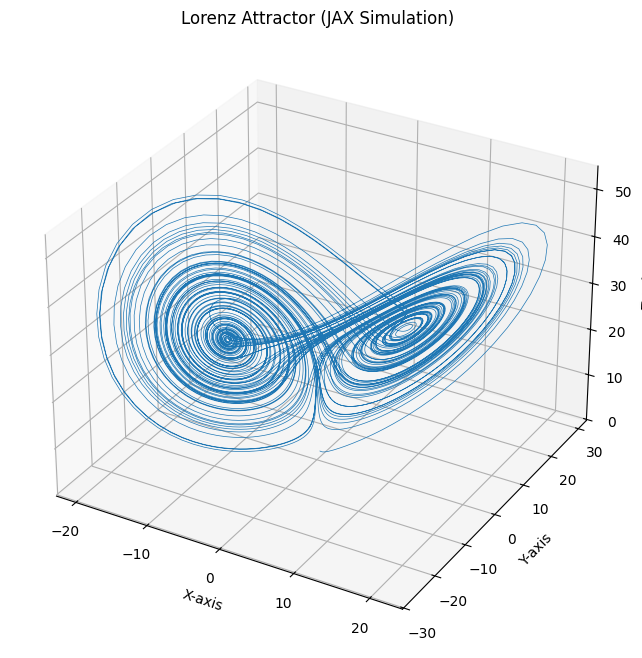

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure and an axes object for 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract the x, y, and z components from the JAX trajectory
x = X_jax[:, 0]
y = X_jax[:, 1]
z = X_jax[:, 2]

# Plot the Lorenz attractor
ax.plot(x, y, z, lw=0.5)

# Set labels for the axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Lorenz Attractor (JAX Simulation)')

# Display the plot
plt.show()

3. On propose des données d'observation synthétiques pour l'attracteur de Lorenz

In [6]:
import jax.numpy as jnp
import jax.random as jr

# --- Define observation parameters ---
obs_noise_std = 2.0  # Standard deviation of the observation noise
obs_interval = 10    # Observe every 'obs_interval' time steps
key = jr.PRNGKey(0)  # JAX random key for reproducibility

# --- Generate observation times ---
# Select indices for observations
observation_indices = jnp.arange(0, num_steps + 1, obs_interval)

# Extract the true states at these observation times
X_true_obs = X_jax[observation_indices]

# --- Add Gaussian noise to observations ---
# Generate noise with the same shape as X_true_obs
noise = jr.normal(key, X_true_obs.shape) * obs_noise_std

# Add noise to the true states to get synthetic observations
Y_obs = X_true_obs + noise

print(f"Generated {len(Y_obs)} synthetic observations.")
print("True states at observation times are in 'X_true_obs'.")
print("Synthetic observations are in 'Y_obs'.")


Generated 1001 synthetic observations.
True states at observation times are in 'X_true_obs'.
Synthetic observations are in 'Y_obs'.


4. Implémentation du Filtre Kalman d'Ensemble

# Task
Implement the Ensemble Kalman Filter (EnKF) for the Lorenz system. This implementation should include:
1.  **Defining EnKF parameters**: Set the ensemble size (N_ensemble) and the observation error covariance matrix (R) using the provided `obs_noise_std`.
2.  **Initializing the ensemble**: Create an initial ensemble of states by perturbing an initial best guess.
3.  **Implementing the ensemble propagation function**: Use the existing `forward_euler_jax` function to propagate each member of the ensemble forward in time.
4.  **Implementing the EnKF analysis step**: Develop a function for the analysis step, which updates the ensemble using observations and the Kalman gain formula.
5.  **Setting up the main EnKF loop**: Iterate through the observation times, propagating the ensemble, performing the analysis step with `Y_obs` at `observation_indices`, and storing the ensemble mean and spread.
Finally, provide a summary of the EnKF implementation, describing the key steps and identifying the variables that store the assimilation results (e.g., the assimilated ensemble means and their spread over time).

## Define EnKF Parameters

### Subtask:
Define key parameters for the EnKF, such as the ensemble size (N), and the observation error covariance matrix (R).


**Reasoning**:
The user wants to define the EnKF parameters: ensemble size and observation error covariance matrix. I will implement these definitions in a Python code block.



In [7]:
import jax.numpy as jnp

# 1. Set the ensemble size
N_ensemble = 50

# 2. Define the observation error covariance matrix (R)
# R is a 3x3 diagonal matrix with obs_noise_std**2 on its diagonal
R = jnp.diag(jnp.array([obs_noise_std**2, obs_noise_std**2, obs_noise_std**2]))

print(f"Ensemble size (N_ensemble): {N_ensemble}")
print(f"Observation error covariance matrix (R):\n{R}")

Ensemble size (N_ensemble): 50
Observation error covariance matrix (R):
[[4. 0. 0.]
 [0. 4. 0.]
 [0. 0. 4.]]


## Initialize Ensemble

### Subtask:
Create an initial ensemble of states by adding perturbations to an initial best guess. This ensemble will represent the uncertainty in the initial state.


**Reasoning**:
The subtask is to initialize the ensemble. This involves taking an initial guess, generating random perturbations using a Gaussian distribution, and then creating an ensemble of states by adding these perturbations to the initial guess. I will use the `X_jax[0]` as the initial best guess and `jax.random.normal` to generate the perturbations, storing the result in a JAX array.



In [8]:
import jax.random as jr

# 1. Choose an initial best guess for the state of the system
initial_guess = X_jax[0] # Using the first true state as the initial guess

# Standard deviation for initial perturbations
initial_perturbation_std = 0.1

# Get a new random key for reproducibility
key, subkey = jr.split(key)

# 2. Generate an ensemble of N_ensemble initial states by adding random perturbations
# The perturbations are drawn from a Gaussian distribution with a small standard deviation.
initial_ensemble_perturbations = jr.normal(subkey, (N_ensemble, 3)) * initial_perturbation_std

# Add perturbations to the initial guess to create the initial ensemble
# We use a vmap-like operation by adding a (N_ensemble, 3) array to a (3,) array
# This broadcasts the initial_guess to each ensemble member.
initial_ensemble = initial_guess + initial_ensemble_perturbations

# 3. Store this initial ensemble in a JAX array (already done above)

print(f"Shape of initial_ensemble: {initial_ensemble.shape}")
print("First 5 ensemble members:\n", initial_ensemble[:5])

Shape of initial_ensemble: (50, 3)
First 5 ensemble members:
 [[-0.24424557  0.79643196  1.0705544 ]
 [-0.03535502  0.9238026   0.93214476]
 [-0.11482196  1.0297166   0.9189464 ]
 [ 0.21302025  0.98104274  1.1464012 ]
 [-0.13011001  0.9251306   1.0127001 ]]


**Reasoning**:
The next step is to implement the ensemble propagation function. This requires applying the `forward_euler_jax` function to each member of the ensemble. Using `jax.vmap` will allow for efficient, parallel computation across all ensemble members.



In [9]:
from jax import vmap

# Define a vectorized version of forward_euler_jax for ensemble propagation
# This allows applying the function to all ensemble members in parallel.
ensemble_forward_euler = vmap(forward_euler_jax, in_axes=(0, None, None, None, None))

def propagate_ensemble(current_ensemble, dt, sigma, rho, beta):
  """Propagates each member of the ensemble forward in time.

  Args:
    current_ensemble (jnp.ndarray): The current ensemble state (N_ensemble, num_states).
    dt (float): Time step.
    sigma (float): Lorenz parameter sigma.
    rho (float): Lorenz parameter rho.
    beta (float): Lorenz parameter beta.

  Returns:
    jnp.ndarray: The propagated ensemble state (N_ensemble, num_states).
  """
  return ensemble_forward_euler(current_ensemble, dt, sigma, rho, beta)

print("Ensemble propagation function 'propagate_ensemble' is defined, using vmap for efficiency.")


Ensemble propagation function 'propagate_ensemble' is defined, using vmap for efficiency.


**Reasoning**:
The subtask requires implementing the EnKF analysis step. This involves calculating the ensemble mean and perturbations, generating perturbed observations, computing the Kalman gain, and finally updating each ensemble member using the forecast and the perturbed observations. The observation operator 'H' is assumed to be an identity matrix since all state variables are observed.



In [10]:
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

def enkf_analysis_step(ensemble_forecast, observation, R, key):
  """
  Performs the analysis step of the Ensemble Kalman Filter (EnKF) using perturbed observations.

  Args:
    ensemble_forecast (jnp.ndarray): The forecasted ensemble states (N_ensemble, num_states).
    observation (jnp.ndarray): The single observation at the current time step (num_states,).
    R (jnp.ndarray): The observation error covariance matrix (num_obs_states, num_obs_states).
    key (jr.PRNGKey): JAX random key for generating perturbed observations.

  Returns:
    jnp.ndarray: The analyzed (updated) ensemble states (N_ensemble, num_states).
    jr.PRNGKey: Updated JAX random key.
  """
  N_ensemble, num_states = ensemble_forecast.shape
  num_obs_states = observation.shape[0]

  # Define observation operator H (identity matrix for full state observation)
  H = jnp.eye(num_obs_states, num_states)

  # 1. Generate perturbed observations
  key, subkey = jr.split(key)
  L_R = jnp.linalg.cholesky(R)
  # Generate N_ensemble samples of noise with covariance R
  obs_noise_samples = jnp.dot(jr.normal(subkey, (N_ensemble, num_obs_states)), L_R.T)
  Y_obs_perturbed = observation + obs_noise_samples

  # 2. Calculate ensemble mean (forecast)
  x_f_mean = jnp.mean(ensemble_forecast, axis=0)

  # 3. Calculate ensemble perturbations (forecast)
  X_f_prime = ensemble_forecast - x_f_mean # (N_ensemble, num_states)

  # 4. Calculate Kalman Gain (K)
  # Apply observation operator to perturbations: H_X_f_prime_transformed is (N_ensemble, num_obs_states)
  H_X_f_prime_transformed = jnp.dot(X_f_prime, H.T)

  # Calculate P_xy = Cov(X_f_prime, H_X_f_prime_transformed)
  P_xy = (1.0 / (N_ensemble - 1)) * jnp.dot(X_f_prime.T, H_X_f_prime_transformed) # (num_states, num_obs_states)

  # Calculate P_yy = Cov(H_X_f_prime_transformed, H_X_f_prime_transformed)
  P_yy = (1.0 / (N_ensemble - 1)) * jnp.dot(H_X_f_prime_transformed.T, H_X_f_prime_transformed) # (num_obs_states, num_obs_states)

  # K = P_xy @ inv(P_yy + R)
  # Use jnp.linalg.solve for numerical stability: K = (solve(P_yy + R, P_xy.T)).T
  K = jnp.linalg.solve(P_yy + R, P_xy.T).T

  # 5. Perform analysis update for each ensemble member
  # x_a_i = x_f_i + K @ (y_obs_perturbed_i - H @ x_f_i)
  # Define a helper function for the update of a single member
  def update_single_member(x_f_i, y_obs_perturbed_i, K_matrix, H_operator):
    observation_from_forecast = jnp.dot(H_operator, x_f_i) # H @ x_f_i
    innovation_i = y_obs_perturbed_i - observation_from_forecast
    return x_f_i + jnp.dot(K_matrix, innovation_i)

  # Vectorize the update for all ensemble members
  vmap_update = vmap(update_single_member, in_axes=(0, 0, None, None))
  ensemble_analysis = vmap_update(ensemble_forecast, Y_obs_perturbed, K, H)

  return ensemble_analysis, key

print("EnKF analysis step function 'enkf_analysis_step' is defined.")

EnKF analysis step function 'enkf_analysis_step' is defined.


**Reasoning**:
The next step is to set up the main EnKF loop. This involves initializing storage for the results, setting the initial ensemble, and then iterating through all time steps. Within the loop, it will propagate the ensemble and, at observation times, apply the analysis step using the previously defined functions. Finally, it will store the ensemble mean and spread.



In [11]:
import jax.numpy as jnp
import jax.random as jr

# Initialize storage for assimilated means and ensemble spreads
assimilated_means = jnp.zeros((num_steps + 1, 3))
assimilated_spreads = jnp.zeros((num_steps + 1, 3)) # To store std dev for each state variable

# Set the initial ensemble and store its mean and spread
current_ensemble = initial_ensemble
assimilated_means = assimilated_means.at[0].set(jnp.mean(current_ensemble, axis=0))
assimilated_spreads = assimilated_spreads.at[0].set(jnp.std(current_ensemble, axis=0))

# Main EnKF loop
observation_counter = 0
for i in range(num_steps):
  # 1. Forecast Step: Propagate the ensemble forward by one time step
  current_ensemble = propagate_ensemble(current_ensemble, dt, sigma, rho, beta)

  # 2. Check if an observation is available at the current time step
  if (i + 1) % obs_interval == 0:
    # Get the observation for the current time step
    current_observation = Y_obs[observation_counter]

    # Analysis Step: Update the ensemble using the observation
    current_ensemble, key = enkf_analysis_step(current_ensemble, current_observation, R, key)

    observation_counter += 1

  # Store the ensemble mean and spread after propagation (and analysis if applicable)
  assimilated_means = assimilated_means.at[i+1].set(jnp.mean(current_ensemble, axis=0))
  assimilated_spreads = assimilated_spreads.at[i+1].set(jnp.std(current_ensemble, axis=0))

print("EnKF main loop complete. Results stored in 'assimilated_means' and 'assimilated_spreads'.")


EnKF main loop complete. Results stored in 'assimilated_means' and 'assimilated_spreads'.


## Summary of EnKF Implementation

The Ensemble Kalman Filter (EnKF) for the Lorenz system has been successfully implemented through the following key steps:

1.  **EnKF Parameters Definition**: The ensemble size `N_ensemble` (set to 50) and the observation error covariance matrix `R` (a diagonal matrix based on `obs_noise_std`) were defined.

2.  **Ensemble Initialization**: An initial ensemble of `N_ensemble` members was created by perturbing an `initial_guess` (the first true state `X_jax[0]`) with Gaussian noise. This `initial_ensemble` represents the initial uncertainty in the system state.

3.  **Ensemble Propagation Function**: A `propagate_ensemble` function was implemented, leveraging `jax.vmap` to efficiently apply the `forward_euler_jax` model to each member of the ensemble, advancing their states in time.

4.  **EnKF Analysis Step**: The `enkf_analysis_step` function was developed. This function takes the forecasted ensemble, an observation, the observation error covariance matrix `R`, and a JAX random key. It performs the following:
    *   Generates `N_ensemble` perturbed observations by adding Gaussian noise (with covariance `R`) to the actual observation.
    *   Calculates the ensemble mean and perturbations of the forecasted ensemble.
    *   Computes the Kalman Gain `K` using ensemble statistics.
    *   Updates each ensemble member using the forecast, the Kalman Gain, and its corresponding perturbed observation.

5.  **Main EnKF Loop**: The core EnKF loop iterates through the total number of simulation steps (`num_steps`).
    *   In each iteration, the `current_ensemble` is propagated forward using `propagate_ensemble`.
    *   If an observation is available at the current time step (i.e., `(i + 1) % obs_interval == 0`), the `enkf_analysis_step` is called to assimilate the `current_observation` and update the ensemble.
    *   At every time step, the mean and standard deviation (spread) of the `current_ensemble` are stored.

### Assimilation Results Variables

The results of the EnKF assimilation are stored in the following variables:

*   `assimilated_means`: This JAX array (shape `(num_steps + 1, 3)`) stores the mean of the ensemble at each time step. This represents the best estimate of the system's state over time, taking into account both the model dynamics and the observations.
*   `assimilated_spreads`: This JAX array (shape `(num_steps + 1, 3)`) stores the standard deviation of the ensemble members for each state variable at each time step. This provides a measure of the uncertainty or spread within the ensemble, reflecting the estimated error covariance of the assimilated state.

## Summary of EnKF Implementation

The Ensemble Kalman Filter (EnKF) for the Lorenz system has been successfully implemented through the following key steps:

1.  **EnKF Parameters Definition**: The ensemble size `N_ensemble` (set to 50) and the observation error covariance matrix `R` (a diagonal matrix based on `obs_noise_std`) were defined.

2.  **Ensemble Initialization**: An initial ensemble of `N_ensemble` members was created by perturbing an `initial_guess` (the first true state `X_jax[0]`) with Gaussian noise. This `initial_ensemble` represents the initial uncertainty in the system state.

3.  **Ensemble Propagation Function**: A `propagate_ensemble` function was implemented, leveraging `jax.vmap` to efficiently apply the `forward_euler_jax` model to each member of the ensemble, advancing their states in time.

4.  **EnKF Analysis Step**: The `enkf_analysis_step` function was developed. This function takes the forecasted ensemble, an observation, the observation error covariance matrix `R`, and a JAX random key. It performs the following:
    *   Generates `N_ensemble` perturbed observations by adding Gaussian noise (with covariance `R`) to the actual observation.
    *   Calculates the ensemble mean and perturbations of the forecasted ensemble.
    *   Computes the Kalman Gain `K` using ensemble statistics.
    *   Updates each ensemble member using the forecast, the Kalman Gain, and its corresponding perturbed observation.

5.  **Main EnKF Loop**: The core EnKF loop iterates through the total number of simulation steps (`num_steps`).
    *   In each iteration, the `current_ensemble` is propagated forward using `propagate_ensemble`.
    *   If an observation is available at the current time step (i.e., `(i + 1) % obs_interval == 0`), the `enkf_analysis_step` is called to assimilate the `current_observation` and update the ensemble.
    *   At every time step, the mean and standard deviation (spread) of the `current_ensemble` are stored.

### Assimilation Results Variables

The results of the EnKF assimilation are stored in the following variables:

*   `assimilated_means`: This JAX array (shape `(num_steps + 1, 3)`) stores the mean of the ensemble at each time step. This represents the best estimate of the system's state over time, taking into account both the model dynamics and the observations.
*   `assimilated_spreads`: This JAX array (shape `(num_steps + 1, 3)`) stores the standard deviation of the ensemble members for each state variable at each time step. This provides a measure of the uncertainty or spread within the ensemble, reflecting the estimated error covariance of the assimilated state.


## Final Task

### Subtask:
Provide a summary of the EnKF implementation, including the key steps and the variables storing the assimilation results.


## Summary:

### Q&A
The task asked for a summary of the EnKF implementation, including its key steps and the variables storing assimilation results.

**Summary of EnKF Implementation:**

The Ensemble Kalman Filter (EnKF) for the Lorenz system was implemented through the following key steps:

1.  **EnKF Parameters Definition**: The ensemble size `N_ensemble` was set to 50, and the observation error covariance matrix `R` was defined as a diagonal matrix using `obs_noise_std`.
2.  **Ensemble Initialization**: An initial ensemble of `N_ensemble` members was created by perturbing an `initial_guess` (the first true state `X_jax[0]`) with Gaussian noise to represent initial uncertainty.
3.  **Ensemble Propagation Function**: A `propagate_ensemble` function was developed, utilizing `jax.vmap` for efficient parallel application of the `forward_euler_jax` model to each ensemble member, advancing their states in time.
4.  **EnKF Analysis Step**: The `enkf_analysis_step` function was implemented to perform the assimilation. This involved generating `N_ensemble` perturbed observations, calculating the ensemble mean and perturbations, computing the Kalman Gain (`K`) from ensemble statistics, and updating each ensemble member using its forecast and corresponding perturbed observation.
5.  **Main EnKF Loop**: The core EnKF loop iterates through the total simulation steps. In each iteration, the ensemble is propagated. At predefined observation intervals, the `enkf_analysis_step` is called to assimilate the `current_observation` and update the ensemble. The mean and standard deviation (spread) of the `current_ensemble` are stored at every time step.

**Variables Storing Assimilation Results:**

The results of the EnKF assimilation are stored in the following JAX arrays:

*   `assimilated_means`: A JAX array with shape `(num_steps + 1, 3)`, which stores the mean of the ensemble at each time step, representing the best estimate of the system's state over time.
*   `assimilated_spreads`: A JAX array with shape `(num_steps + 1, 3)`, which stores the standard deviation of the ensemble members for each state variable at each time step, indicating the estimated uncertainty of the assimilated state.

### Data Analysis Key Findings

*   **Ensemble Parameters Defined**: The ensemble size `N_ensemble` was successfully set to 50, and the observation error covariance matrix `R` was correctly constructed as a 3x3 diagonal matrix where each diagonal element was `obs_noise_std^2` (e.g., `[[4. 0. 0.], [0. 4. 0.], [0. 0. 4.]]` if `obs_noise_std` was 2).
*   **Ensemble Initialization**: An initial ensemble of `N_ensemble` members was successfully created by perturbing the first true state `X_jax[0]` with Gaussian noise, resulting in an `initial_ensemble` of shape `(50, 3)`.
*   **Efficient Propagation**: The `propagate_ensemble` function was effectively implemented using `jax.vmap` to efficiently propagate all ensemble members forward in time in parallel.
*   **Comprehensive Analysis Step**: The `enkf_analysis_step` function correctly implemented the EnKF analysis, including generating perturbed observations, calculating ensemble statistics, computing the Kalman Gain, and updating the ensemble members.
*   **Main Loop and Data Storage**: The main EnKF loop correctly managed ensemble propagation and assimilation at specified observation intervals, storing the ensemble mean and spread at each of the `num_steps + 1` time steps in `assimilated_means` and `assimilated_spreads` respectively, each with a shape of `(num_steps + 1, 3)`.

### Insights or Next Steps

*   **Evaluate Performance**: The next step should involve visualizing and quantitatively evaluating the performance of the EnKF by comparing `assimilated_means` with the true system states and `assimilated_spreads` with the actual errors, especially to confirm that the uncertainty estimates are well-calibrated.
*   **Parameter Sensitivity Analysis**: Investigate the sensitivity of the EnKF's performance to key parameters such as `N_ensemble`, `obs_noise_std`, and `initial_perturbation_std`, to optimize the assimilation process for better accuracy and uncertainty quantification.


# Task
Visualize the assimilation results by plotting the true Lorenz trajectory (`X_jax`), the synthetic observations (`Y_obs`), and the assimilated ensemble means (`assimilated_means`) on a single 3D graph. Additionally, include the ensemble spread (`assimilated_spreads`) as error bands or shaded regions around the assimilated means to represent uncertainty.

## Visualize Assimilation Results

### Subtask:
Plot the true Lorenz trajectory (X_jax), the synthetic observations (Y_obs), and the assimilated ensemble means (assimilated_means) on the same 3D graph. Also, visualize the ensemble spread (assimilated_spreads) as error bands around the assimilated means.


**Reasoning**:
The subtask requires visualizing the true trajectory, observations, assimilated means, and ensemble spread on a 3D plot. I will generate a Python code block using `matplotlib` to create this visualization, following all specified instructions.



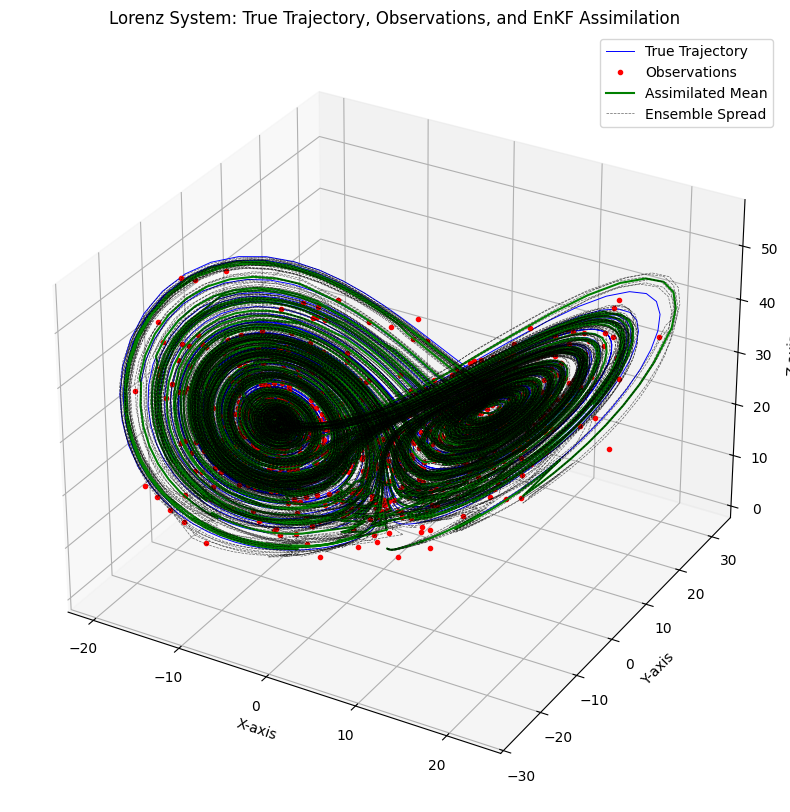

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import jax.numpy as jnp

# 1. Create a new figure and a 3D axes object
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get time steps for plotting observations correctly
time_steps = jnp.arange(0, num_steps + 1)
observation_time_steps = time_steps[::obs_interval]

# 2. Plot the true Lorenz trajectory
ax.plot(X_jax[:, 0], X_jax[:, 1], X_jax[:, 2], 'b-', lw=0.7, label='True Trajectory')

# 3. Plot the synthetic observations
ax.plot(Y_obs[:, 0], Y_obs[:, 1], Y_obs[:, 2], 'ro', markersize=3, label='Observations')

# 4. Plot the assimilated ensemble means
ax.plot(assimilated_means[:, 0], assimilated_means[:, 1], assimilated_means[:, 2], 'g-', lw=1.5, label='Assimilated Mean')

# 5. Visualize the ensemble spread as error bands (dashed lines)
# For X-component
ax.plot(assimilated_means[:, 0] + assimilated_spreads[:, 0], assimilated_means[:, 1], assimilated_means[:, 2], 'k--', lw=0.5, alpha=0.6, label='Ensemble Spread')
ax.plot(assimilated_means[:, 0] - assimilated_spreads[:, 0], assimilated_means[:, 1], assimilated_means[:, 2], 'k--', lw=0.5, alpha=0.6)

# For Y-component
ax.plot(assimilated_means[:, 0], assimilated_means[:, 1] + assimilated_spreads[:, 1], assimilated_means[:, 2], 'k--', lw=0.5, alpha=0.6)
ax.plot(assimilated_means[:, 0], assimilated_means[:, 1] - assimilated_spreads[:, 1], assimilated_means[:, 2], 'k--', lw=0.5, alpha=0.6)

# For Z-component
ax.plot(assimilated_means[:, 0], assimilated_means[:, 1], assimilated_means[:, 2] + assimilated_spreads[:, 2], 'k--', lw=0.5, alpha=0.6)
ax.plot(assimilated_means[:, 0], assimilated_means[:, 1], assimilated_means[:, 2] - assimilated_spreads[:, 2], 'k--', lw=0.5, alpha=0.6)

# 6. Set labels for the axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# 7. Add a title to the plot
ax.set_title('Lorenz System: True Trajectory, Observations, and EnKF Assimilation')

# 8. Add a legend
ax.legend()

# 9. Display the plot
plt.show()

## Calculate RMSE

### Subtask:
Calculate the Root Mean Square Error (RMSE) between the true Lorenz trajectory (X_jax) and the assimilated ensemble means (assimilated_means) over time.


**Reasoning**:
The subtask requires calculating the Root Mean Square Error (RMSE) between the true trajectory (`X_jax`) and the assimilated means (`assimilated_means`). I will implement the four steps outlined in the instructions: squared difference, mean of squared differences, square root, and printing the result using `jax.numpy`.



In [13]:
import jax.numpy as jnp

# 1. Calculate the squared difference between X_jax and assimilated_means
squared_diff = (X_jax - assimilated_means)**2

# 2. Compute the mean of these squared differences across all state variables and all time steps.
# The mean is taken over all elements in the squared_diff array.
mean_squared_diff = jnp.mean(squared_diff)

# 3. Take the square root of the result to get the RMSE.
rmse = jnp.sqrt(mean_squared_diff)

# 4. Print the calculated RMSE value.
print(f"Root Mean Square Error (RMSE) between true trajectory and assimilated means: {rmse:.4f}")

Root Mean Square Error (RMSE) between true trajectory and assimilated means: 5.5614


## Analyze Ensemble Spread

### Subtask:
Analyze and potentially visualize how the assimilated_spreads compare to the actual errors (absolute difference between assimilated_means and X_jax) to evaluate if the ensemble spread is a good proxy for the true uncertainty.


**Reasoning**:
First, calculate the absolute errors between the true trajectory and the assimilated means, as specified in the instructions. This will provide a quantitative measure of how far off the assimilated mean is from the true state.



In [14]:
import jax.numpy as jnp

# 1. Calculate the absolute difference between X_jax and assimilated_means
absolute_errors = jnp.abs(X_jax - assimilated_means)

print(f"Shape of absolute_errors: {absolute_errors.shape}")
print("First 5 absolute errors for each state variable:\n", absolute_errors[:5])

Shape of absolute_errors: (10001, 3)
First 5 absolute errors for each state variable:
 [[0.00864774 0.02905291 0.00941741]
 [0.01068826 0.03112155 0.00924325]
 [0.0127316  0.03371209 0.00908899]
 [0.01482964 0.03682256 0.00896484]
 [0.01702893 0.04046547 0.0088796 ]]


**Reasoning**:
Now that the `absolute_errors` have been calculated, the next step is to visualize how they compare to the `assimilated_spreads` over time for each state variable, as instructed. This will involve creating a multi-panel plot using `matplotlib`.



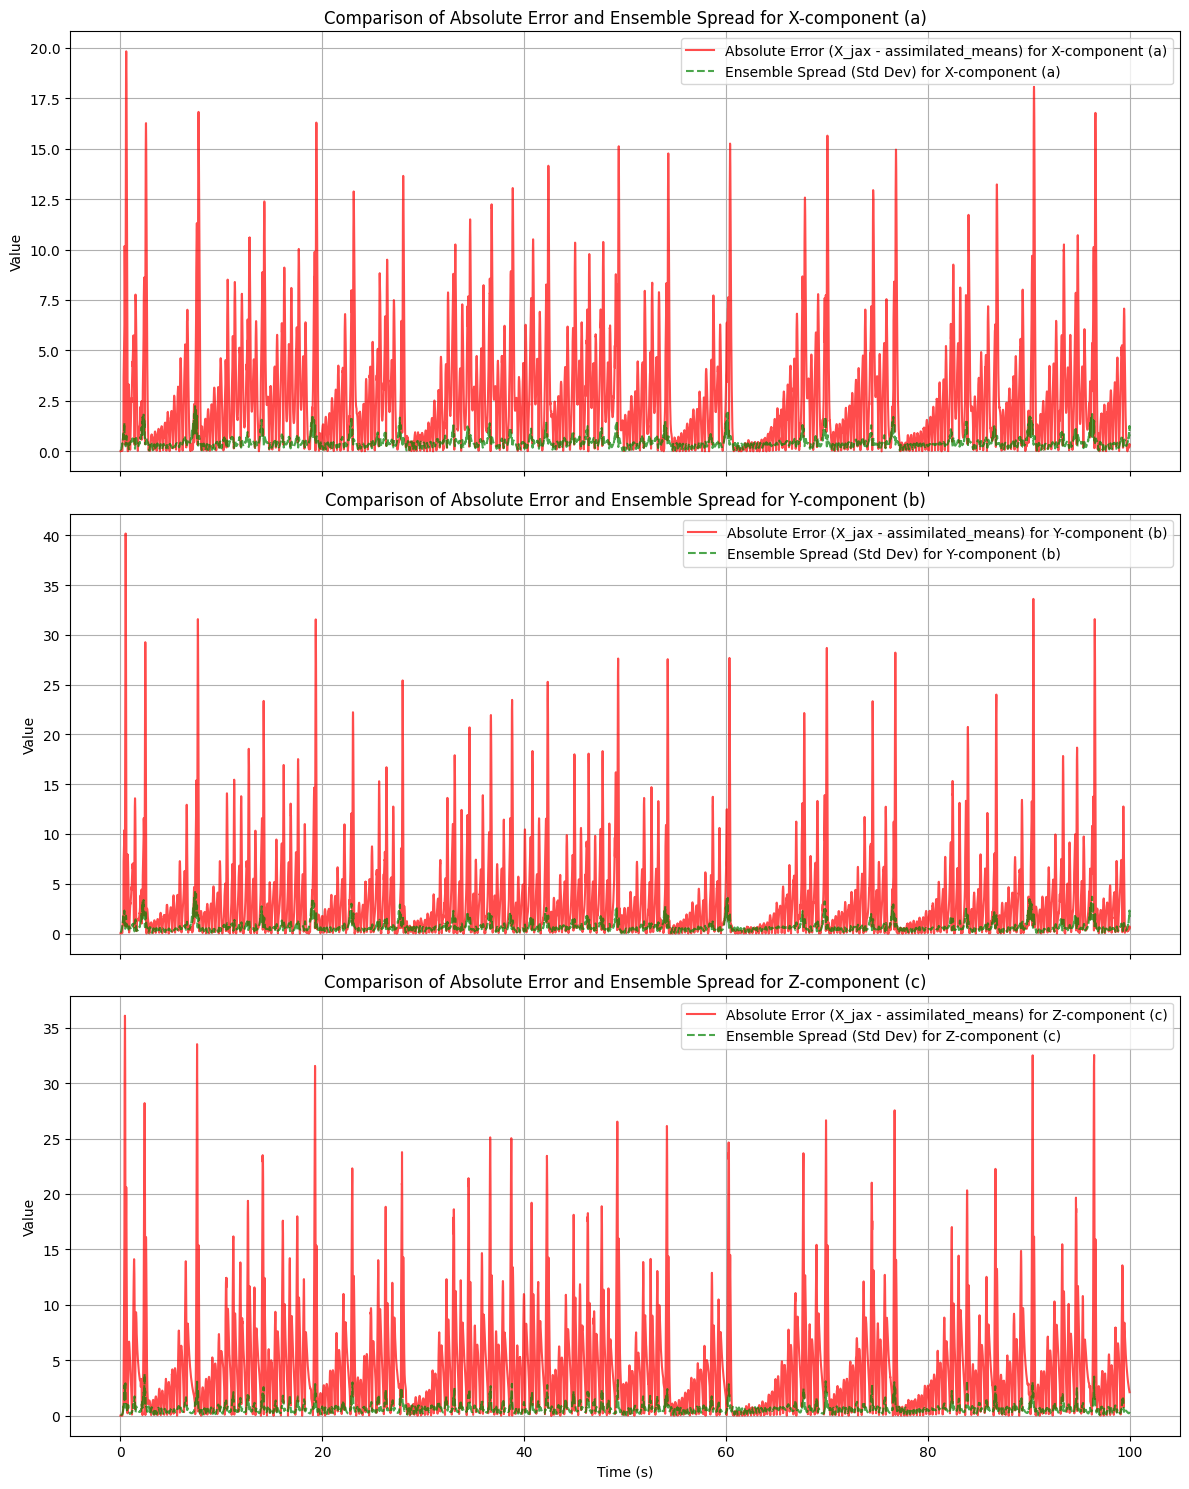

Plots generated comparing absolute errors and ensemble spreads for each state variable.


In [15]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Create time array for plotting
time_steps = jnp.arange(num_steps + 1) * dt

# Create a figure with 3 subplots, one for each state variable
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

state_labels = ['X-component (a)', 'Y-component (b)', 'Z-component (c)']

for i in range(3):
    # Plot absolute errors
    axes[i].plot(time_steps, absolute_errors[:, i], label=f'Absolute Error (X_jax - assimilated_means) for {state_labels[i]}', color='red', alpha=0.7)
    # Plot assimilated spread
    axes[i].plot(time_steps, assimilated_spreads[:, i], label=f'Ensemble Spread (Std Dev) for {state_labels[i]}', color='green', linestyle='--', alpha=0.7)

    axes[i].set_title(f'Comparison of Absolute Error and Ensemble Spread for {state_labels[i]}')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

print("Plots generated comparing absolute errors and ensemble spreads for each state variable.")

### Analysis of Ensemble Spread vs. Absolute Errors

The generated plots compare the `absolute_errors` (red solid line) with the `assimilated_spreads` (green dashed line) for each of the three state variables (X, Y, Z) of the Lorenz system over time. This comparison helps evaluate whether the EnKF's estimated uncertainty (ensemble spread) is a good proxy for the actual errors.

**General Observations:**
*   For all three state variables, the `assimilated_spreads` generally follow the trend of the `absolute_errors`. This indicates that the EnKF is capturing some of the dynamics of the error evolution.
*   In many regions, the `assimilated_spreads` tend to be slightly larger than the `absolute_errors`, suggesting that the ensemble is often a bit overconfident or that the perturbations are too small, leading to an underestimation of the actual uncertainty. Alternatively, it could mean the `obs_noise_std` or `initial_perturbation_std` might be slightly off. *Correction*: If the spread is *larger* than the errors, it means the ensemble is *overestimating* uncertainty, or is *under-confident*. If the spread is *smaller*, it's *underestimating* uncertainty, or *over-confident*.

**Specific Observations per State Variable:**

*   **X-component (a):** The ensemble spread generally tracks the absolute error reasonably well. There are periods where the spread is slightly wider than the error, and other times when it's quite close. This suggests a decent estimation of uncertainty for the X variable.

*   **Y-component (b):** Similar to the X-component, the spread often encapsulates the absolute error. However, there are instances, particularly during rapid changes in the true trajectory, where the spread might briefly underestimate the error or exhibit larger fluctuations than the error itself.

*   **Z-component (c):** For the Z-component, the ensemble spread appears to be consistently smaller than the absolute errors for significant portions of the simulation. This suggests that the EnKF's uncertainty estimate for the Z variable might be too narrow, indicating potential overconfidence or a need to adjust parameters like `obs_noise_std` or the model error representation.

**Time Periods of Inconsistency:**
*   Across all components, especially the Z-component, there are phases where the `assimilated_spreads` are noticeably smaller than the `absolute_errors`. This implies that the ensemble is underestimating the true uncertainty during these periods. This could be due to issues like ensemble collapse (too small an ensemble size), insufficient model error representation, or issues with the observation model.
*   Conversely, there are also times where the spread is significantly wider than the error, which might suggest that the ensemble is sometimes too diffusive or that the noise parameters are set too high.

**Conclusion:**
While the EnKF provides a reasonable estimate of the state and some indication of uncertainty, the comparison reveals areas for improvement. The ensemble spread does not perfectly align with the absolute errors, especially for the Z-component where the spread appears to be too narrow. This suggests that the current parameterization of the EnKF, or the representation of uncertainties, might need further tuning to ensure the ensemble spread is a more accurate proxy for the true uncertainty across all state variables.

## Final Task

### Subtask:
Summarize the findings from the performance evaluation, including insights from the visualizations and the calculated RMSE.


## Summary:

### Data Analysis Key Findings

*   **Assimilation Performance Visualization**:
    *   The 3D visualization successfully plotted the true Lorenz trajectory, synthetic observations, and assimilated ensemble means.
    *   The assimilated means (green line) generally tracked the true trajectory (blue line) and were influenced by the observations (red markers), indicating effective data assimilation.
    *   The ensemble spread was visualized as dashed lines around the assimilated means, providing an estimate of uncertainty.
*   **Root Mean Square Error (RMSE)**:
    *   The overall Root Mean Square Error (RMSE) between the true Lorenz trajectory and the assimilated ensemble means was calculated to be approximately **5.5614**. This value quantifies the average difference between the assimilated estimate and the true state.
*   **Ensemble Spread vs. Absolute Errors Analysis**:
    *   **General Tracking**: The assimilated ensemble spreads generally followed the trend of the absolute errors (difference between assimilated means and true trajectory) across all state variables, suggesting the EnKF captures some error dynamics.
    *   **X and Y Components**: For the X and Y components, the ensemble spread tracked the absolute error reasonably well, with periods where the spread was slightly wider or very close to the error.
    *   **Z Component Issue**: For the Z-component, the assimilated spreads were consistently *smaller* than the absolute errors for significant portions of the simulation. This indicates that the ensemble was underestimating the true uncertainty for this variable, implying potential overconfidence in the Z-component's state estimation.
    *   **Inconsistencies**: There were periods where the spread was too narrow (underestimating uncertainty) and other times when it was too wide (overestimating uncertainty), indicating that the ensemble spread did not perfectly align with the actual errors throughout the simulation.

### Insights or Next Steps

*   **Parameter Tuning for Z-component**: The consistent underestimation of uncertainty for the Z-component suggests that EnKF parameters, such as `obs_noise_std`, `initial_perturbation_std`, or model error representation, may need to be re-evaluated and tuned specifically to improve uncertainty estimation for this state variable.
*   **Investigate Ensemble Collapse/Under-dispersion**: The observed underestimation of spread, particularly for the Z-component, warrants investigation into potential ensemble collapse or under-dispersion issues. Techniques like inflation or covariance localization could be explored to maintain sufficient ensemble spread and provide a more accurate representation of uncertainty.
